# 3D ResNet

Basic + Augmentations (invert, rotate, zoom, blur, noise) + Batch Norm + Dropout (0.35) + l2

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

import datetime
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.training import train
from src.model.evaluation import plot_training_history, show_simple_metrics, show_metrics

In [2]:
import tensorflow as tf

RANDOM_SEED = 300785674475887
tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.1
Num GPUs Available:  1


## Setup

In [3]:
%%time

ROOT_DIR = '../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False
    
class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path, 
    ROOT_DIR, 
    split=(0.8, 0.15, 0.05), 
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weights (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq
    
model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../tmp\logs\20201229-211343
Wall time: 3.51 ms


In [4]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = 'ResNet18'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
    'l2_beta': 0.0005,
#     'l2_beta': None,
    'dropout': 0.35,
#     'dropout': None,
    'output_bias': initial_bias,
    'batch_norm': True,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00025,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 200,
    'patience': 30,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_auc', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_auc', 'mode': 'max'},
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0.2, 5), # probability, degrees
        'zoom': (0.2, 0.20),
        'shear': (0, 0), # probability, degrees
        'blur': (0.2, 0.85),
        'noise': (0.2, 0.00020)
    },
#     'augmentations': False,
    'batch_size': 10,
#     'model_checkpoint_callback': False,
}

## Train

In [5]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 104, 128, 104)     0         
_________________________________________________________________
my_res_net (MyResNet)        (None, 512)               11770304  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [6]:
# load_checkpoint(model, DEFAULT_CHECKPOINT_DIRECTORY_LOCAL, '20201229-134047', 'cp-0032.ckpt')

In [7]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/device:GPU:0']


In [8]:
%%time

model, checkpoint_dir, history = train(
    model,
    train_seq,
    test_seq,
    CHECKPOINT_DIRECTORY,
    LOG_DIRECTORY,
    DATA_DIR,
    **train_config
)

model key: 20201229-211343
checkpoint dir: ../../tmp\checkpoints\20201229-211343
log dir: ../../tmp\logs\20201229-211343
loading ../../tmp\data-v3\train_x.npy, ../../tmp\data-v3\train_y.npy...
loading ../../tmp\data-v3\val_x.npy, ../../tmp\data-v3\val_y.npy...
training...
Epoch 1/200
41/41 [==============================] - ETA: 0s - loss: 3.2329 - recall: 0.5000 - precision: 0.5000 - auc: 0.4934 - categorical_accuracy: 0.5000
Epoch 00001: val_auc improved from -inf to 0.40470, saving model to ../../tmp\checkpoints\20201229-211343\cp-0001.ckpt
41/41 [==============================] - 8s 202ms/step - loss: 3.2329 - recall: 0.5000 - precision: 0.5000 - auc: 0.4934 - categorical_accuracy: 0.5000 - val_loss: 3.1110 - val_recall: 0.3800 - val_precision: 0.3800 - val_auc: 0.4047 - val_categorical_accuracy: 0.3800
Epoch 2/200
40/41 [============================>.] - ETA: 0s - loss: 3.1039 - recall: 0.5100 - precision: 0.5100 - auc: 0.5334 - categorical_accuracy: 0.5100
Epoch 00002: val_auc im

41/41 [==============================] - 6s 158ms/step - loss: 2.5002 - recall: 0.8308 - precision: 0.8308 - auc: 0.9036 - categorical_accuracy: 0.8308 - val_loss: 3.5105 - val_recall: 0.7500 - val_precision: 0.7500 - val_auc: 0.7640 - val_categorical_accuracy: 0.7500
Epoch 17/200
41/41 [==============================] - ETA: 0s - loss: 2.4050 - recall: 0.8134 - precision: 0.8134 - auc: 0.9201 - categorical_accuracy: 0.8134- ETA: 2s - loss: 2.3786 - recall: 0.8200 - precision: 0.8200 - auc: 0.9251 - categoric
Epoch 00017: val_auc did not improve from 0.76400
41/41 [==============================] - 7s 160ms/step - loss: 2.4050 - recall: 0.8134 - precision: 0.8134 - auc: 0.9201 - categorical_accuracy: 0.8134 - val_loss: 2.9478 - val_recall: 0.5200 - val_precision: 0.5200 - val_auc: 0.5637 - val_categorical_accuracy: 0.5200
Epoch 18/200
40/41 [============================>.] - ETA: 0s - loss: 2.3212 - recall: 0.8550 - precision: 0.8550 - auc: 0.9516 - categorical_accuracy: 0.8550
Epoch 0

41/41 [==============================] - 7s 182ms/step - loss: 2.0642 - recall: 0.9403 - precision: 0.9403 - auc: 0.9918 - categorical_accuracy: 0.9403 - val_loss: 2.5808 - val_recall: 0.7600 - val_precision: 0.7600 - val_auc: 0.8455 - val_categorical_accuracy: 0.7600
Epoch 32/200
40/41 [============================>.] - ETA: 0s - loss: 2.0555 - recall: 0.9400 - precision: 0.9400 - auc: 0.9917 - categorical_accuracy: 0.9400
Epoch 00032: val_auc improved from 0.84550 to 0.85220, saving model to ../../tmp\checkpoints\20201229-211343\cp-0032.ckpt
41/41 [==============================] - 8s 185ms/step - loss: 2.0551 - recall: 0.9403 - precision: 0.9403 - auc: 0.9918 - categorical_accuracy: 0.9403 - val_loss: 2.5623 - val_recall: 0.7500 - val_precision: 0.7500 - val_auc: 0.8522 - val_categorical_accuracy: 0.7500
Epoch 33/200
41/41 [==============================] - ETA: 0s - loss: 2.0777 - recall: 0.9254 - precision: 0.9254 - auc: 0.9875 - categorical_accuracy: 0.9254
Epoch 00033: val_auc i

41/41 [==============================] - ETA: 0s - loss: 1.9706 - recall: 0.9602 - precision: 0.9602 - auc: 0.9962 - categorical_accuracy: 0.9602- ETA: 6s - loss: 1.9497 - recall: 0.9714 - precision: 0.9714 - auc: 0.999
Epoch 00048: val_auc did not improve from 0.86530
41/41 [==============================] - 7s 172ms/step - loss: 1.9706 - recall: 0.9602 - precision: 0.9602 - auc: 0.9962 - categorical_accuracy: 0.9602 - val_loss: 2.7706 - val_recall: 0.7300 - val_precision: 0.7300 - val_auc: 0.7900 - val_categorical_accuracy: 0.7300
Epoch 49/200
40/41 [============================>.] - ETA: 0s - loss: 1.9542 - recall: 0.9650 - precision: 0.9650 - auc: 0.9966 - categorical_accuracy: 0.9650
Epoch 00049: val_auc did not improve from 0.86530
41/41 [==============================] - 5s 126ms/step - loss: 1.9540 - recall: 0.9652 - precision: 0.9652 - auc: 0.9966 - categorical_accuracy: 0.9652 - val_loss: 2.8502 - val_recall: 0.7000 - val_precision: 0.7000 - val_auc: 0.7641 - val_categorical_

## Evaluation

Wall time: 209 ms


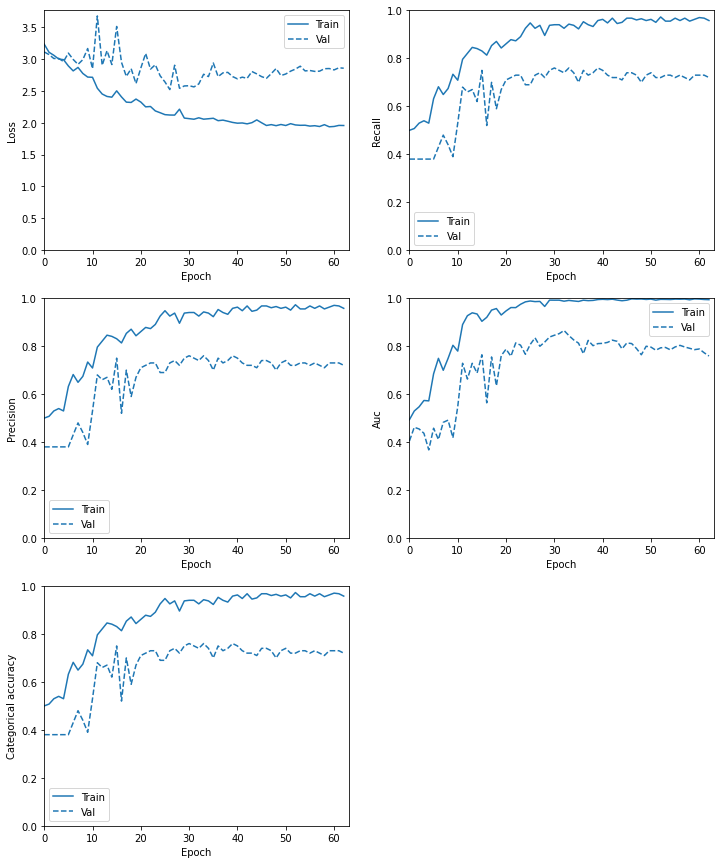

In [9]:
%%time

plot_training_history(history)

In [10]:
%%time

show_simple_metrics(model, test_seq)

loss: 2.50874924659729
recall: 0.7400000095367432
precision: 0.7400000095367432
auc: 0.8652999997138977
categorical_accuracy: 0.7400000095367432

Wall time: 33.7 s


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.7432432432432432
recall: 0.8870967741935484
f1-score: 0.8088235294117647
support: 62


CN
precision: 0.7307692307692307
recall: 0.5
f1-score: 0.5937499999999999
support: 38


micro avg
precision: 0.74
recall: 0.74
f1-score: 0.74
support: 100


macro avg
precision: 0.7370062370062369
recall: 0.6935483870967742
f1-score: 0.7012867647058822
support: 100


weighted avg
precision: 0.7385031185031184
recall: 0.74
f1-score: 0.7270955882352941
support: 100


samples avg
precision: 0.74
recall: 0.74
f1-score: 0.74
support: 100


F1
micro: 0.74
macro: 0.7012867647058822


accuracy_score: 0.74
sensitivity_score: 0.8870967741935484
specificity_score: 0.5


Wall time: 27.2 s


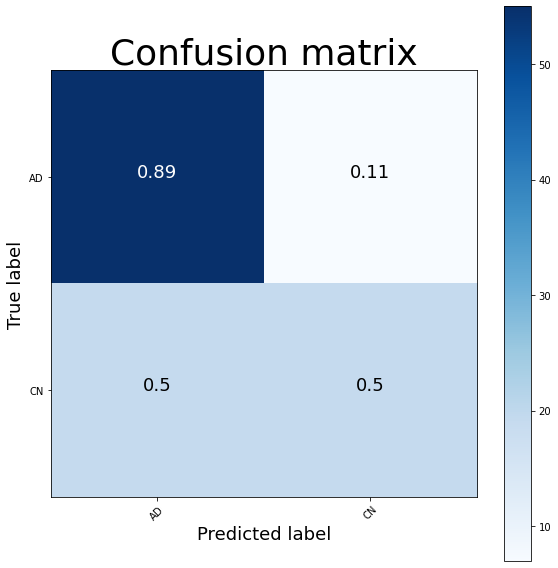

In [11]:
%%time

show_metrics(model, test_seq, class_names)